In [31]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DA/assignment1


In [ ]:
!ls
%cd drive/MyDrive/DA/assignment1
!pwd

In [33]:
!pip install haversine

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import math
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn import datasets, linear_model
import re
from haversine import haversine, Unit

#Read Dataset

In [35]:
df_data_org = pd.read_csv('IndianEarthquakesListUpdateMagnitudes.csv', na_values=np.NaN)
# df_data_org = pd.read_csv('Indian Earthquakes List Update_Magnitudes (1).csv', na_values=np.NaN, skiprows=10, encoding="utf-8")
df_data_org.columns = [x.strip().lower() for x in df_data_org.columns]
print(df_data_org.shape)
display(df_data_org.head())
display(df_data_org.info())
display(df_data_org.describe())

(52989, 20)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,5,7,9,10,11,12,13,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sl. no.,year,month,date,origin time (utc),origin time (ist),magnitude,mw,mb,m_b,ms,ml,lat (n),long (e),depth (km),intensity mm,mmi,mme,location,reference
0,1,-2474,0,0.0,NaN,NaN,7.5000,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0.0,NaN,NaN,NaN,NaN,Dr STGR
1,2,-325,0,0.0,NaN,NaN,7.5000,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0.0,NaN,NaN,NaN,NaN,Dr STGR
2,3,25,0,0.0,NaN,NaN,7.5000,7.5,NaN,6.969202899,7.260619977,7.427072403,72.9,33.72,0.0,NaN,NaN,NaN,NaN,Dr STGR
3,4,26,5,10.0,08.19.10.0,NaN,6.1397,6.1397,5.737047101,5.737047101,5.698851894,5.999685205,17.3,80.1,NaN,NaN,NaN,NaN,NaN,NEIC
4,5,26,5,10.0,08.19.10.0,NaN,6.1397,6.1397,5.737047101,5.737047101,6.075520196,5.999685205,26,97,80.0,NaN,NaN,NaN,Myanmar,G-R


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52989 entries, 0 to 52988
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sl. no.            52989 non-null  int64  
 1   year               52989 non-null  int64  
 2   month              52971 non-null  object 
 3   date               52932 non-null  float64
 4   origin time (utc)  21186 non-null  object 
 5   origin time (ist)  426 non-null    object 
 6   magnitude          40935 non-null  float64
 7   mw                 50485 non-null  object 
 8   mb                 12283 non-null  object 
 9   m_b                50497 non-null  object 
 10  ms                 52823 non-null  object 
 11  ml                 52823 non-null  object 
 12  lat (n)            52989 non-null  object 
 13  long (e)           52989 non-null  object 
 14  depth (km)         50811 non-null  float64
 15  intensity mm       41 non-null     object 
 16  mmi                0 n

None

,sl. no.,year,date,magnitude,depth (km),mmi,mme
count,52989.000000,52989.000000,52932.000000,40935.000000,50811.000000,0.0,0.0
mean,26480.004246,1991.584669,16.393958,4.537564,45.569867,NaN,NaN
std,15296.743693,41.964962,8.969178,0.625875,55.517009,NaN,NaN
min,1.000000,-2474.000000,0.000000,2.000000,0.000000,NaN,NaN
25%,13233.000000,1986.000000,9.000000,4.200000,10.000000,NaN,NaN
50%,26480.000000,1999.000000,16.000000,4.400000,33.000000,NaN,NaN
75%,39727.000000,2005.000000,25.000000,4.800000,55.000000,NaN,NaN
max,52974.000000,2019.000000,31.000000,9.100000,831.200000,NaN,NaN


#**Processing Features**

##Target Column : MW  
**Moment magnitude (Mw)** : Today the moment magnitude scale is preferred because it works over a wider range of earthquake sizes and is applicable globally. To get a better idea of the strength of the shaking and damage, the Moment Magnitude Scale was developed to capture all the different seismic waves from an earthquake to worldwide seismic networks.

Remove rows having empty values in MW column. As MW has to be predicted, we should have the actual ground truth values for all data.

In [36]:
df_data_org = df_data_org[df_data_org['mw'].notna()]
print(df_data_org.shape)
display(df_data_org.info())

(50485, 20)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50485 entries, 0 to 52988
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sl. no.            50485 non-null  int64  
 1   year               50485 non-null  int64  
 2   month              50477 non-null  object 
 3   date               50474 non-null  float64
 4   origin time (utc)  19253 non-null  object 
 5   origin time (ist)  426 non-null    object 
 6   magnitude          40935 non-null  float64
 7   mw                 50485 non-null  object 
 8   mb                 11423 non-null  object 
 9   m_b                50484 non-null  object 
 10  ms                 50484 non-null  object 
 11  ml                 50484 non-null  object 
 12  lat (n)            50485 non-null  object 
 13  long (e)           50485 non-null  object 
 14  depth (km)         49228 non-null  float64
 15  intensity mm       26 non-null     object 
 16  mmi       

None

Observe if any invalid value exists in MW column. Eg: '#VALUE!' exists.

In [37]:
print(df_data_org['mw'].unique())

['7.5' '6.1397' '7' '6.5' '8.5' '8' '7.3' '5.6' '7.7' '7.6' '7.0' '5.9'
 '6.4' '8.0' '5.0' '6.8' '5.7' '7.8' '3.7' '7.2' '5.8' '4.3' '6.0' '5.2'
 '4.5' '4.6' '5.5' '4.4' '6.3' '4.9' '4.2' '4.7' '5.3' '3.8' '4.1' '3.3'
 '6' '3.2' '5' '3.5' '6.1' '4' '8.1' '6.2' '6.7' '6.6393' '6.95155'
 '5.3903' '8.7' '7.2638' '6.57685' '6.70175' '6.0148' '7.014' '6.82665'
 '5.70255' '7.1' '5.765' '6.32705' '5.1' '5.4' '8.3' '6.5144' '6.7642'
 '6.9' '3' '7.1389' '6.45195' '6.2646' '6.6' '4.8907' '5.2654' '5.8899'
 '5.5152' '6.07725' '5.6401' '4.8' '5.82745' '5.95235' '5.45275' '5.20295'
 '5.57765' '5.07805' '9.1' '4.0' '4.0805' '6.2539' '5.38454' '4.94986'
 '5.49321' '6.03656' '5.1672' '5.60188' '5.71055' '5.27587' '5.81922'
 '4.62385' '5.05853' '6.14523' '4.51518' '4.84119' '4.32033469'
 '4.51594069' '5.10275869' '4.71154669' '4.40651' '4.73252' '5.92789'
 '6.36257' '3.9' '6.68858' '3.4' '6.091994445' '4.61374369' '4.80934969'
 '5.5468' '5.1052' '4.222' '5.4364' '4.774' '4.6636' '5.326' '5.9884'
 '5.65

Remove those invalid values from the MW column.

In [38]:
df_data_org = df_data_org.loc[df_data_org['mw'] != '#VALUE!']
df_data_org['mw'] = df_data_org['mw'].apply(lambda x: round(float(x),1))
print(df_data_org.shape)
print(df_data_org['mw'][:10])

(50482, 20)
0    7.5
1    7.5
2    7.5
3    6.1
4    6.1
5    7.0
6    6.5
7    8.5
8    8.0
9    7.3
Name: mw, dtype: float64


##Processing Month  
Month may give us the information regarding which season / part of the year do earthquakes occur frequently.

Check if month column has any invalid values. Eg: 0, space and NaN.

In [39]:
print(df_data_org['month'].unique())

['0' '5' '6' '00' '02' '09' '06' '07' '10' '01' nan '03' '05' '12' '04'
 '08' '11' '1' '8' '7' '2' '3' '4' '9' ' ' 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
 9.0 10.0 11.0 12.0]


Remove the invalid values from month column and convert valid values to numeric format. Replace the NaN values with the median.

In [40]:
df_data_org['month'] = df_data_org['month'].apply(lambda x: float(x) if (pd.notna(x) and (x != ' ')) else np.NaN)
df_data_org['month'] = df_data_org['month'].apply(lambda x: float(1) if (x == 0) else x)
df_data_org['month'].fillna(df_data_org['month'].median(), inplace = True)
# df_data_org['month'] = df_data_org['month'].astype(int)
print(df_data_org['month'].value_counts())

1.0     6208
12.0    5172
3.0     4496
10.0    4446
4.0     4247
7.0     3967
2.0     3908
5.0     3824
8.0     3798
11.0    3651
6.0     3430
9.0     3335
Name: month, dtype: int64


As year column has only 2 negative values, remove the respecive rows from the dataset.

In [41]:
print(df_data_org[df_data_org['year']<=0]['year'].value_counts())
df_data_org = df_data_org[df_data_org['year']>0]
print(df_data_org.shape)

-2474    1
-325     1
Name: year, dtype: int64
(50480, 20)


##Processing Latitude and Longitude

**Latitude & Longitude** : are the units that represent the coordinates at geographic coordinate system. Both longitude and latitude are angles measured with the center of the earth as an origin.  
  
**Latitude** : Latitudes measure an angle up from the equator (latitudes to the south are negative). Range is 0 to 90 degrees in the North and 0 to -90 degrees in the South.   

**Longitude** : A longitude is an angle from the prime merdian, measured to the east (longitudes to the west are negative). Range is 0 to 180 degrees in the East and 0 to -180 degrees in the West.  

Hence, latitudes and longitudes can tell us which locations are prone to earthquakes.

Few values in latitude column have the directions N and S mentioned, while others have only float values which are by default considered to be in the North (as mentioned in the heading)

In [42]:
print(df_data_org['lat (n)'].unique())

[72.9 17.3 26.0 ... '12.1°N' '20.0°N' '31.8°N']


Convert the South values to North by negating them. Then extract the float values from the strings and convert everything to float. There are a few rows with latitude values out of range (>90) in the positive side. Replace them with 90-(X-90) as they are only a little out of range (till 100). (Eg: 100 will be converted to 80 degrees). There are no out of range values on the negatve side.

In [43]:
rgx = r"[-+]?\d*\.\d+|\d+"
df_data_org['lat (n)'] = df_data_org['lat (n)'].apply(lambda x: round(float(x),1) if (pd.notna(x) and type(x)!=str) else x)
df_data_org['lat (n)'] = df_data_org['lat (n)'].apply(lambda x: round(-float(re.findall(rgx,x)[0]),1) if (pd.notna(x) and type(x)==str and ('S' in x or 's' in x)) else x)
df_data_org['lat (n)'] =  df_data_org['lat (n)'].apply(lambda x: round(float(re.findall(rgx,x)[0]),1) if (pd.notna(x) and type(x)==str) else x)
display(df_data_org['lat (n)'].describe())
print()
display(df_data_org[df_data_org['lat (n)']>90]['lat (n)'].describe())
print()
df_data_org['lat (n)'] = df_data_org['lat (n)'].apply(lambda x: round(90-(x-90),1) if (pd.notna(x) and x > 90) else x)
df_data_org['lat (n)'].fillna(df_data_org['lat (n)'].mode(), inplace = True)
display(df_data_org['lat (n)'].describe())

count    50480.000000
mean        59.264859
std         31.110017
min        -60.700000
25%         27.500000
50%         70.800000
75%         91.800000
max        100.000000
Name: lat (n), dtype: float64

count    13512.000000
mean        94.587034
std          2.018319
min         90.100000
25%         93.200000
50%         94.300000
75%         95.800000
max        100.000000
Name: lat (n), dtype: float64

count    50480.000000
mean        56.809233
std         28.475462
min        -60.700000
25%         27.500000
50%         70.800000
75%         83.700000
max         90.000000
Name: lat (n), dtype: float64

Few values in longitude column have the directions E and W mentioned, while others have only float values which are by default considered to be in the East (as mentioned in the heading)

In [44]:
print(df_data_org['long (e)'].unique())

[33.72 80.1 97.0 ... '73.0°E' '86.5°E' '72.8°E']


Convert the West values to East by negating them. Then extract the float values from the strings and convert everything to float. There is only one row with longitude value out of range (>180) in the positive side. Replace it with X%180 as it is too much out of range (9128), which is most probably an error. There are no out of range values on the negatve side.

In [45]:
df_data_org['long (e)'] = df_data_org['long (e)'].apply(lambda x: round(float(x),1) if (pd.notna(x) and type(x)!=str) else x)
df_data_org['long (e)'] = df_data_org['long (e)'].apply(lambda x: round(-float(re.findall(rgx,x)[0]),1) if (pd.notna(x) and type(x)==str and ('W' in x or 'w' in x)) else x)
df_data_org['long (e)'] =  df_data_org['long (e)'].apply(lambda x: round(float(re.findall(rgx,x)[0]),1) if (pd.notna(x) and type(x)==str) else x)
display(df_data_org['long (e)'].describe())
print()
display(df_data_org[df_data_org['long (e)']>180]['long (e)'].describe())
print()
df_data_org['long (e)'] = df_data_org['long (e)'].apply(lambda x: round(x%180,1) if (pd.notna(x) and x > 180) else x)
df_data_org['long (e)'].fillna(round(df_data_org['long (e)'].mode(),1), inplace = True)
display(df_data_org['long (e)'].describe())

count    50480.000000
mean        50.357474
std         53.189495
min       -179.700000
25%         26.100000
50%         36.900000
75%         90.000000
max       9128.200000
Name: long (e), dtype: float64

count       1.0
mean     9128.2
std         NaN
min      9128.2
25%      9128.2
50%      9128.2
75%      9128.2
max      9128.2
Name: long (e), dtype: float64

count    50480.000000
mean        50.179186
std         34.593432
min       -179.700000
25%         26.100000
50%         36.900000
75%         90.000000
max        179.900000
Name: long (e), dtype: float64

##Processing Depth

**Depth** : Shallow earthquakes are between 0 and 70 km deep; intermediate earthquakes, 70 - 300 km deep; and deep earthquakes, 300 - 700 km deep. In general, deeper earthquakes are less damaging because their energy dissipates before it reaches the surface.  

Depth of the earthquake can tell us the intensity of the earthquake.
  
Replace the null depth values with the median.

In [46]:
df_data_org['depth (km)'].fillna(round(df_data_org['depth (km)'].median(),1), inplace = True)

#**Haversine Distance**  

The Haversine formula calculates the shortest distance between two points on a sphere using their latitudes and longitudes measured along the surface. It is important for use in navigation. 

As latitudes and longitudes are given in degrees, they cannot be directly used for calculating distances between 2 points using Euclidean distance along with other features (eg. in KNN). Eg: Longitude 180E and -180E (actual West) are the same points but L1 distance between them would come as 360. Hence, we need to convert degrees to a format suitable for taking euclid distance.  
  
Here, we create a new column called geo_dist which calculates and stores Haversine distance (int miles) of each point from the origin (0,0). These values can further be used to get difference between 2 locations with the actual latitude and longitude columns.

In [47]:
df_dist = []
origin = (0,0)
for i, row in df_data_org.iterrows():
    cur_loc = (row['lat (n)'],row['long (e)'])
    df_dist.append(haversine(origin, cur_loc, unit=Unit.MILES))
df_data_org['geo_dist'] = df_dist
print(df_data_org['geo_dist'].describe())

count    50480.000000
mean      5816.092705
std        638.647131
min       2432.055157
25%       5266.089958
50%       5873.625518
75%       6224.439076
max      11287.684246
Name: geo_dist, dtype: float64


In [48]:
print(df_data_org.shape)
display(df_data_org.head())
display(df_data_org.info())
display(df_data_org.describe())

(50480, 21)


,sl. no.,year,month,date,origin time (utc),origin time (ist),magnitude,mw,mb,m_b,ms,ml,lat (n),long (e),depth (km),intensity mm,mmi,mme,location,reference,geo_dist
2,3,25,1.0,0.0,NaN,NaN,7.5000,7.5,NaN,6.969202899,7.260619977,7.427072403,72.9,33.7,0.0,NaN,NaN,NaN,NaN,Dr STGR,5240.055003
3,4,26,5.0,10.0,08.19.10.0,NaN,6.1397,6.1,5.737047101,5.737047101,5.698851894,5.999685205,17.3,80.1,33.0,NaN,NaN,NaN,NaN,NEIC,5565.618141
4,5,26,5.0,10.0,08.19.10.0,NaN,6.1397,6.1,5.737047101,5.737047101,6.075520196,5.999685205,26.0,97.0,80.0,NaN,NaN,NaN,Myanmar,G-R,6652.904246
5,6,50,1.0,0.0,NaN,NaN,7.0000,7.0,NaN,6.516304348,6.686567164,6.902413431,69.5,37.1,0.0,NaN,NaN,NaN,NaN,Dr STGR,5097.739358
6,7,110,1.0,0.0,NaN,NaN,6.5000,6.5,NaN,6.063405797,6.112514351,6.37775446,76.5,18.1,0.0,NaN,NaN,NaN,NaN,Dr STGR,5332.611383


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50480 entries, 2 to 52988
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sl. no.            50480 non-null  int64  
 1   year               50480 non-null  int64  
 2   month              50480 non-null  float64
 3   date               50469 non-null  float64
 4   origin time (utc)  19250 non-null  object 
 5   origin time (ist)  426 non-null    object 
 6   magnitude          40933 non-null  float64
 7   mw                 50480 non-null  float64
 8   mb                 11420 non-null  object 
 9   m_b                50479 non-null  object 
 10  ms                 50479 non-null  object 
 11  ml                 50479 non-null  object 
 12  lat (n)            50480 non-null  float64
 13  long (e)           50480 non-null  float64
 14  depth (km)         50480 non-null  float64
 15  intensity mm       26 non-null     object 
 16  mmi                0 n

None

,sl. no.,year,month,date,magnitude,mw,lat (n),long (e),depth (km),mmi,mme,geo_dist
count,50480.000000,50480.000000,50480.000000,50469.000000,40933.000000,50480.000000,50480.000000,50480.000000,50480.000000,0.0,0.0,50480.000000
mean,27092.891581,1993.131517,6.320345,16.403495,4.537420,4.578282,56.809233,50.179186,45.334145,NaN,NaN,5816.092705
std,15153.201649,34.071987,3.647405,8.978870,0.625548,0.619998,28.475462,34.593432,55.431256,NaN,NaN,638.647131
min,2.000000,25.000000,1.000000,0.000000,2.000000,1.700000,-60.700000,-179.700000,0.000000,NaN,NaN,2432.055157
25%,13912.750000,1988.000000,3.000000,9.000000,4.200000,4.200000,27.500000,26.100000,10.000000,NaN,NaN,5266.089958
50%,27109.500000,2000.000000,6.000000,16.000000,4.400000,4.500000,70.800000,36.900000,33.000000,NaN,NaN,5873.625518
75%,40350.250000,2005.000000,10.000000,25.000000,4.800000,4.900000,83.700000,90.000000,53.400000,NaN,NaN,6224.439076
max,52974.000000,2019.000000,12.000000,31.000000,9.100000,9.100000,90.000000,179.900000,831.200000,NaN,NaN,11287.684246


In [49]:
df_data_org.to_csv('processed_earthquake_extra.csv', index=False)

#**Estimating the Threshold for MW**  

According to [Wikipedia](https://en.wikipedia.org/wiki/Richter_magnitude_scale), Ritcher's scale magnitude (ML) of 4.0 or above is considered to be light earthquake which is noticable. I found no such threshold directly for MW scale. Hence we need to somehow convert 4.0ML to its equivalent MW value. 

To learn mapping between ML and MW, copy these columns to a new dataframe and remove rows from it which have NaN ML values.

In [50]:
df_data_org['ml'] = df_data_org['ml'].apply(lambda x: round(float(x),1))
print(df_data_org['ml'].unique())
df_mags = df_data_org[['mw','ml']].copy()
print(df_mags.shape)
df_mags = df_mags.dropna()
print(df_mags['ml'].unique())
print(df_mags.shape)

[7.4 6.  6.9 6.4 8.5 8.  7.2 5.4 7.6 7.5 5.7 6.3 4.8 6.7 5.5 7.7 3.4 7.1
 5.6 4.1 5.9 5.  4.3 4.4 5.3 4.2 6.2 4.7 4.  4.5 5.1 nan 3.5 3.9 3.  2.9
 3.2 3.8 8.1 6.1 6.6 6.5 5.2 8.7 7.  4.9 8.3 6.8 2.7 4.6 5.8 9.1 3.6 3.1
 7.3 2.8 2.5 2.3 3.3 2.6 2.4 3.7 1.7 7.8 1.4 1.3 2.2 8.6 8.4 2.  1.9 1.8
 9. ]
(50480, 2)
[7.4 6.  6.9 6.4 8.5 8.  7.2 5.4 7.6 7.5 5.7 6.3 4.8 6.7 5.5 7.7 3.4 7.1
 5.6 4.1 5.9 5.  4.3 4.4 5.3 4.2 6.2 4.7 4.  4.5 5.1 3.5 3.9 3.  2.9 3.2
 3.8 8.1 6.1 6.6 6.5 5.2 8.7 7.  4.9 8.3 6.8 2.7 4.6 5.8 9.1 3.6 3.1 7.3
 2.8 2.5 2.3 3.3 2.6 2.4 3.7 1.7 7.8 1.4 1.3 2.2 8.6 8.4 2.  1.9 1.8 9. ]
(50479, 2)


In [51]:
print(df_mags.shape)
display(df_mags.head())
display(df_mags.info())
display(df_mags.describe())

(50479, 2)


,mw,ml
2,7.5,7.4
3,6.1,6.0
4,6.1,6.0
5,7.0,6.9
6,6.5,6.4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50479 entries, 2 to 52988
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mw      50479 non-null  float64
 1   ml      50479 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB


None

,mw,ml
count,50479.000000,50479.000000
mean,4.578248,4.373508
std,0.619956,0.645525
min,1.700000,1.300000
25%,4.200000,4.000000
50%,4.500000,4.300000
75%,4.900000,4.700000
max,9.100000,9.100000


##Linear Regression for Finding MW Threshold
To learn the mapping from ML to MW, fit a Linear Regressor on the new dataframe and predict the MW value for 4.0ML. We got the value as 4.219MW (~ 4.2MW) which becomes the threshold for classifcation of earthquakes.

In [52]:
regr = linear_model.LinearRegression()
regr.fit(np.expand_dims(df_mags['ml'].values,1), df_mags['mw'].values)
Tml = np.array([[4.0]])
Tmw = regr.predict(Tml)
print(Tmw)

[4.2199202]


Plotting the MW threshold on the histogram.

MW Threshold = 4.2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


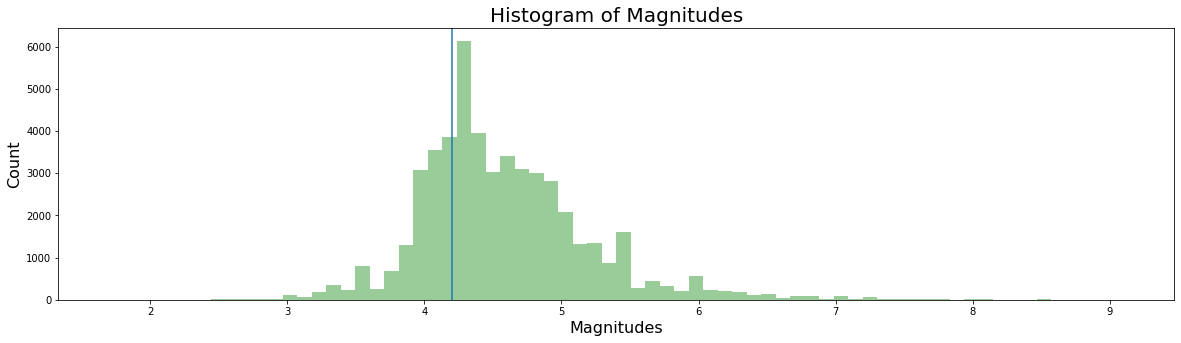

In [53]:
T = round(Tmw[0],1)
print("MW Threshold =",T)

plt.figure(figsize = (20, 5))
sns.distplot(df_data_org['mw'], color = 'green', kde = False, bins=df_data_org['mw'].nunique())
plt.title('Histogram of Magnitudes', fontsize = 20)
plt.xlabel('Magnitudes', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.axvline(x=T)
plt.show()

##Binarizing the MW Column for Classification  
**class 0 (MW < T)** : No earthquake occurred / not felt  
**class 1 (MW >= T)** : Earthquake occurred / felt  
  
As we can see, we get a skewed dataset where class0 has lesser rows than class1

In [54]:
print(df_data_org.loc[df_data_org['mw'] < T].shape)
print(df_data_org.loc[df_data_org['mw'] >= T].shape)

(10721, 21)
(39759, 21)


In [55]:
dy = (df_data_org['mw'] >= T).values
dn = (df_data_org['mw'] < T).values

In [56]:
df_data_org['mw'] = dy.astype(int)

In [57]:
df_data_org.to_csv('binarized_earthquake_42_extra.csv', index=False)

#**Removing Extra Features**  
**Sl. no** : serial number is not required  
**Magnitude / MB / MS / ML** : not required as we have considered MW magnitude  
**Intensity MM / MMI / MME** : These have very few to 0 non-null rows  
**Location** : This column has very few country names    
**Origin Time (IST / UST)** : These columns also have very few non-null values  
**Date** : Day of the month is a very specific information which cannot be generalized for predicting eathquakes  
**Lat / Long** : They are not needed as we have converted them into Haversine distances from origin as a new column geo_dist  
**Reference** : It has the names of many different organizations which provided the information of the earthquake. It does not seam feasible to encode (one-hot) them as few organizations repeat only once or twice and also many rows do not have a reference.  

In [58]:
print(df_data_org['reference'].nunique())
print(df_data_org['reference'].value_counts())

37
Dr STGR        30466
NEIC / USGS    10134
ISC             4808
IMD             1568
NEIC             951
J & S            586
 ISC              91
ISS/T-S           46
G-R               34
T-S               31
MALIK             28
PDE               24
USGS              16
GERI              15
G-R/BDA           13
LEE/CM            10
LEE                9
ISS                8
CHAN               6
HRVD               6
PDE/T-S            6
T-S/G-R            6
ISR                5
OLD                5
RO                 4
G-R/T-S            4
BCI                3
SHL                3
BDA                2
NGRI               2
BDA/CM             2
GSI                1
LEE/T-S            1
CM/G-R             1
CM/ISS             1
CM/LEE             1
G-R/CM             1
Name: reference, dtype: int64


In [59]:
df_data_org.drop(['sl. no.','mb','m_b','ms','ml','intensity mm','mmi','mme','location','reference','origin time (utc)','origin time (ist)','magnitude','date','lat (n)','long (e)'], axis=1, inplace=True)
print(df_data_org.shape)
display(df_data_org.head())
display(df_data_org.info())
display(df_data_org.describe())

(50480, 5)


,year,month,mw,depth (km),geo_dist
2,25,1.0,1,0.0,5240.055003
3,26,5.0,1,33.0,5565.618141
4,26,5.0,1,80.0,6652.904246
5,50,1.0,1,0.0,5097.739358
6,110,1.0,1,0.0,5332.611383


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50480 entries, 2 to 52988
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        50480 non-null  int64  
 1   month       50480 non-null  float64
 2   mw          50480 non-null  int64  
 3   depth (km)  50480 non-null  float64
 4   geo_dist    50480 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 2.3 MB


None

,year,month,mw,depth (km),geo_dist
count,50480.000000,50480.000000,50480.000000,50480.000000,50480.000000
mean,1993.131517,6.320345,0.787619,45.334145,5816.092705
std,34.071987,3.647405,0.408997,55.431256,638.647131
min,25.000000,1.000000,0.000000,0.000000,2432.055157
25%,1988.000000,3.000000,1.000000,10.000000,5266.089958
50%,2000.000000,6.000000,1.000000,33.000000,5873.625518
75%,2005.000000,10.000000,1.000000,53.400000,6224.439076
max,2019.000000,12.000000,1.000000,831.200000,11287.684246


###Saving final processed dataset.

In [60]:
df_data_org.to_csv('binarized_earthquake_42.csv', index=False)

#**Ideas for Additional / Derived Features**  


*   Time to period of the day : morning, noon, night (Problem : many missing values)
*   Train a model to find best values for missing data and use those attributes  
*   Get additional information of the location where earthquake took place with the help of Geo APIs. eg: continent, altitude, etc

